In [99]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [100]:
L = 1
T = 1
Ns = [10, 20, 50, 100, 200, 500, 1000] 
tau = 0.1
lam = 1e-4

In [101]:
init = lambda x, y, t: np.cos(np.pi * x) * np.sin(5 * np.pi * y)

bound_x0 = lambda x, y, t: np.sin(5 * np.pi * y) * np.exp(-50 * np.pi**2 * lam * t)
bound_x1 = lambda x, y, t: -np.sin(5 * np.pi * y) * np.exp(-50 * np.pi**2 * lam * t)

th_sol = lambda x, y, t: np.cos(np.pi * x) * np.sin(5*np.pi * y)*np.exp(-50 * np.pi**2 * lam * t)

In [102]:
def my_solver(A, d):
    n = len(d)

    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    for i in range(n):
        b[i] = A[i,i]
        if i > 0:
            a[i] = A[i, i -1]
        if i < n-1:
            c[i] = A[i, i + 1]
    
    x = np.zeros(n)
    p = np.zeros(n)
    q = np.zeros(n)
    
    p[1] = -c[0]/b[0]
    q[1] = d[0]/b[0]
    
    for i in range(1, n-1):
        p[i+1] = -c[i]/(a[i]*p[i] + b[i])
        q[i+1] = (d[i] - a[i]*q[i])/(a[i]*p[i] + b[i])
    x[n-1] = (d[n-1] - a[n-1]*q[n-1])/(p[n-1]*a[n-1] + b[n-1])
    
    for i in range(n-2, -1, -1):
        x[i] = x[i+1]*p[i+1] + q[i+1]
        
    return x

In [103]:
def gen_grid(size_sp, t_end, num_sp, tau):
    num_t = int(t_end / tau) + 1
    grid = np.zeros((num_t, num_sp + 1, num_sp + 1))
    return grid, num_sp, num_t

In [104]:
def set_bound_cond(grid, N):
    NS = N + 1
    NT = int(T/tau) + 1
    
    for i in range(NS):
        for j in range(NS):
            grid[0, i, j] = init(j * h, i * h, 0)

    
    for k in range(NT):
        for i in range(NS):
            grid[k, i, 0] = bound_x0(0, i * h, tau * k)
            grid[k, i, -1] = bound_x1(1, i * h, tau * k)
            
    grid[:, 0, :] = 0
    grid[:, -1, :] = 0

In [105]:
grid, _, _ = gen_grid(L, T, N, tau)
set_bound_cond(grid, N)

In [106]:
NS = N + 1
x = np.arange(0,1,(L/NS))
y = np.arange(0,1,(L/NS))

xs, ys = np.meshgrid(x, y)

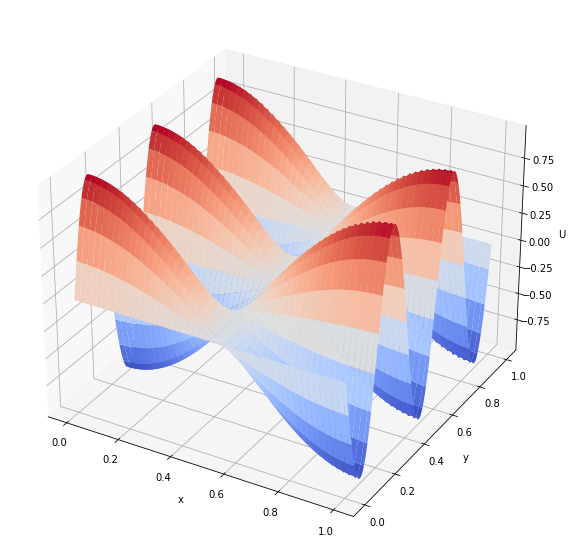

In [107]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xs, ys, grid[0, :, :], cmap=cm.coolwarm)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("U")
plt.show()

In [108]:
errors = []

for N in Ns:
        
    NT = int(T / tau) + 1
    NS = N + 1
    h = L / NS
    
    sig_x = 25 * lam * tau / h**2
    sig_y = lam * tau / h**2
    
    grid = np.zeros((NT, NS, NS))
    
    for i in range(NS):
        for j in range(NS):
            grid[0, i, j] = init(j * h, i * h, 0)
    
    for k in range(NT):
        for i in range(NS):
            grid[k, i, 0] = bound_x0(0, i * h, k * tau)
            grid[k, i, -1] = bound_x1(1, i * h, k * tau)
            
    grid[:, 0, :] = 0
    grid[:, -1, :] = 0
    
    A = np.eye(NS)
    d = np.zeros(NS)
    
    x_turn = True
    
    for k in range(NT-1):
        for i in range(1, NS-1):

            d[0] = grid[k+1, i, 0]
            d[-1] = grid[k+1, i, -1]

            for j in range(1, NS-1):
                A[j, j-1] = sig_x
                A[j, j+1] = sig_x
                A[j, j] = -2 * sig_x - 2 * sig_y - 1
                d[j] = -grid[k, i, j] - sig_y * grid[k, i+1, j] - sig_y * grid[k, i-1, j]

            grid[k+1, i, :] = my_solver(A, d)

        
            
        if k == T // (2 * tau):
            err_mat = np.matrix([[np.abs(th_sol(w*h, v*h, (k+1)*tau) - grid[k+1, v, w]) for w in range(NS)] for v in range(NS)])
            errors.append(np.amax(err_mat))
            print(N, np.amax(err_mat))
    

10 0.9656974188316969
20 0.6635955026159954
50 0.2957642080844213
100 0.15112298691996182
200 0.076166830401735
500 0.030584065022063074
1000 0.0230278763207048


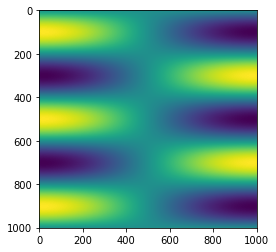

In [109]:
plt.imshow(grid[5, :, :])

In [110]:
errors

[0.9656974188316969,
 0.6635955026159954,
 0.2957642080844213,
 0.15112298691996182,
 0.076166830401735,
 0.030584065022063074,
 0.0230278763207048]

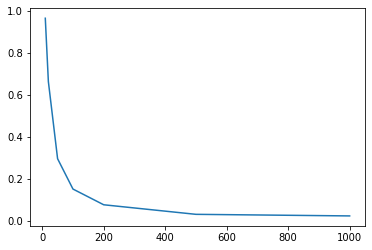

In [112]:
plt.plot(Ns, errors)

In [113]:
Nslog = [np.log(x) for x in Ns]
errlog = [np.log(x) for x in errors]

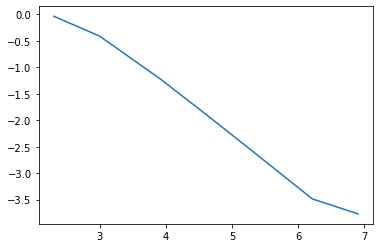

In [114]:
plt.plot(Nslog, errlog)